# Building a micro grid system with a renewable share constraint

The energy system model was generated in yesterdays tutorial "2_tutorial_micro_grid.ipynb". It can be described as following:

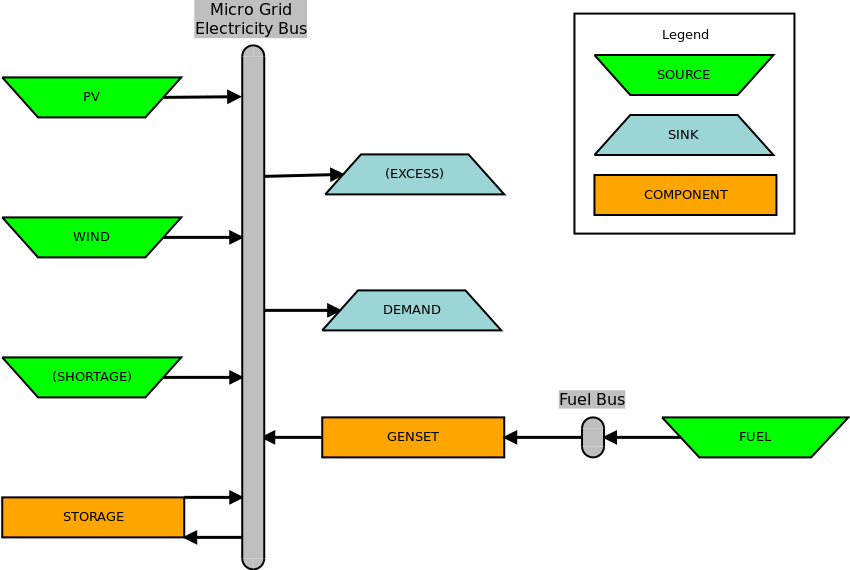

Even when adding a customized constraint to an oemof model, the initial model building is identical:

In [1]:
# importing packages
import os
import pandas as pd
from matplotlib import pyplot as plt

import oemof.solph as solph
from oemof.solph import constraints
import oemof.outputlib as outputlib
from oemof.tools import economics
from oemof.tools import logger #logger to document progress
import logging

# Define screen level of logger
logger.define_logging(screen_level=logging.INFO)

# initialize energy system
duration_hours = 5
cost_ratio_timeinterval = duration_hours/(365*24)
timeindex = pd.date_range('1/1/2017', periods=duration_hours, freq='H')
energysystem = solph.EnergySystem(timeindex=timeindex)

# loading input data
logging.info('Loading timeseries')
full_filename = '2_timeseries.csv'
timeseries = pd.read_csv(full_filename, sep=',')

# Defining fix parameters
logging.info('Defining costs')

fuel_price_kWh = 0.6/9.41 # fuel price in currency/kWh

costs = {'wind': {
             'epc': economics.annuity(capex=2000, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'pv': {
             'epc': economics.annuity(capex=750, n=20, wacc=0.05)*cost_ratio_timeinterval},
         'genset': {
             'epc': economics.annuity(capex=300, n=10, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0},
         'storage': {
             'epc': economics.annuity(capex=300, n=5, wacc=0.05)*cost_ratio_timeinterval,
             'var': 0}}

print('\n')

# Creating all oemof components
logging.info('DEFINITION OF OEMOF MODEL:')

logging.info('Electricity bus')
bel = solph.Bus(label='electricity_bus')
energysystem.add(bel)

logging.info('Demand, fixed timeseries')
demand_sink = solph.Sink(label='demand',
                         inputs={bel: solph.Flow(actual_value=timeseries['demand_el'],
                                                 fixed=True,
                                                 nominal_value=500)})
energysystem.add(demand_sink)

logging.info('Excess sink')
excess_sink = solph.Sink(label='excess',
                    inputs={bel: solph.Flow()})
energysystem.add(excess_sink)

logging.info('Wind plant with fixed feed-in timeseries')
wind_plant = solph.Source(label='wind',
                          outputs={
                              bel: solph.Flow(nominal_value=None,
                                              fixed=True,
                                              actual_value=timeseries['wind'],
                                              investment=solph.Investment(
                                                  ep_costs=costs['wind']['epc']))})
energysystem.add(wind_plant)

logging.info('PV plant with fixed feed-in timeseries')
pv_plant = solph.Source(label='pv',
                        outputs={
                            bel: solph.Flow(nominal_value=None,
                                            fixed=True,
                                            actual_value=timeseries['pv'],
                                            investment=solph.Investment(
                                                ep_costs=costs['pv']['epc']))})

energysystem.add(pv_plant)

logging.info('Diesel fuel bus, source and transformer')
bfuel = solph.Bus(label='fuel_bus')

fuel_source = solph.Source(label='diesel',
       outputs={
           bfuel: solph.Flow(nominal_value=None,
                             variable_costs=fuel_price_kWh)}
       )

genset = solph.Transformer(label="genset",
                           inputs={bfuel: solph.Flow()},
                           outputs={bel: solph.Flow(
                               variable_costs=costs['genset']['var'],
                               investment=solph.Investment(
                                   ep_costs=costs['genset']['epc']))},
                           conversion_factors={bel: 0.33}
                           )

energysystem.add(bfuel, fuel_source, genset)

logging.info('Battery storage')
storage = solph.components.GenericStorage(
    label='storage',
    inputs={
        bel: solph.Flow()},
    outputs={
        bel: solph.Flow()},
    loss_rate=0.00,
    initial_storage_level=0.5, 
    min_storage_level = 0.2,
    max_storage_level=0.9,
    invest_relation_input_capacity=1/5,
    invest_relation_output_capacity=1/5,
    inflow_conversion_factor=0.95,
    outflow_conversion_factor=0.95,
    investment=solph.Investment(ep_costs=costs['storage']['epc']))

energysystem.add(storage)

print('\n')
logging.info('Generating linear equation system describing defined energy system')
model = solph.Model(energysystem)

07:27:56-INFO-Path for logging: /home/mh/.oemof/log_files/oemof.log
07:27:56-INFO-Used oemof version: 0.3.1
07:27:56-INFO-Loading timeseries
07:27:56-INFO-Defining costs


07:27:56-INFO-DEFINITION OF OEMOF MODEL:
07:27:56-INFO-Electricity bus
07:27:56-INFO-Demand, fixed timeseries
07:27:56-INFO-Excess sink
07:27:56-INFO-Wind plant with fixed feed-in timeseries
07:27:56-INFO-PV plant with fixed feed-in timeseries
07:27:56-INFO-Diesel fuel bus, source and transformer
07:27:56-INFO-Battery storage


07:27:56-INFO-Generating linear equation system describing defined energy system


Instead of directly processing and solving the linear equation system with the solver, we now add our renewable share constraint. For that, we have to define a function describing the renewable share criterion:

In [2]:
import pyomo.environ as po

def stability_criterion(model, storage, demand_sink, genset, bel, stability_limit, optimize_storage):
    '''
    The stability constraint can be divided into two sub-problems:

    * A minimal stored electricity per timestep, in order to have enough energy stored to fullfill the needs
    * A minimal storage discharge power, to allow sufficiently high storage discharge
    '''
    def stability_rule_capacity(model, t):
        # The first is dependent on the installed capacity and specific technical storage parameters:
        expr = 0
        ## ------- Get demand at t ------- #
        demand = model.flows[bel, demand_sink].actual_value[t] \
            * model.flows[bel, demand_sink].nominal_value
        expr += - stability_limit * demand

        ## ------- Genset generation at t ------- #
        expr += model.flow[genset, bel, t]
        
        ## ------- Get stored capacity storage at t------- #
        print(storage)
        stored_electricity = 0
        if optimize_storage == True:             
            stored_electricity += model.GenericInvestmentStorageBlock.capacity[storage, t]  
            stored_electricity -= storage.min_storage_level[t] * model.GenericInvestmentStorageBlock.invest[storage]
            stored_electricity = stored_electricity * storage.invest_relation_output_capacity * storage.outflow_conversion_factor[t]
        else: 
            stored_electricity += model.GenericStorageBlock.capacity[storage, t] 
            stored_electricity -= storage.min_storage_level[t] * storage.nominal_capacity
            stored_electricity = stored_electricity * storage.invest_relation_output_capacity * storage.outflow_conversion_factor[t] 
            
        expr += stored_electricity 
        logging.info('Expression generated (stability_rule_capacity): %s', expr)
        return (expr >= 0)
    
    def stability_rule_power(model, t):
        #The second can be defined solely on the flows of the energy system:
        expr = 0
        ## ------- Get demand at t ------- #
        demand = model.flows[bel, demand_sink].actual_value[t] \
            * model.flows[bel, demand_sink].nominal_value
            
        expr += - stability_limit * demand
        expr += model.flow[genset, bel, t]
            
        ## ------- Get output power of storage ------- #
        storage_power = 0
        if optimize_storage==True: 
            storage_power += model.InvestmentFlow.invest[storage, bel]
        else: 
            storage_power = model.flows[storage, bel].nominal_value 

        expr += storage_power 
        logging.info('Expression generated (stability_rule_power): %s', expr)
        return (expr >= 0)
    
    #Both constraints are processed with Pyomo to generate a set of linear equations:
    model.stability_constraint_capacity = po.Constraint(model.TIMESTEPS, rule=stability_rule_capacity)
    model.stability_constraint_power = po.Constraint(model.TIMESTEPS, rule=stability_rule_power)
    return model

In [3]:
stability_limit = 0.4
stability_criterion(model, storage, demand_sink, genset, bel, stability_limit, optimize_storage=True)

storage
07:27:56-INFO-Expression generated (stability_rule_capacity): -111.81239648000002 + flow[genset,electricity_bus,0] + (GenericInvestmentStorageBlock.capacity[storage,0] - 0.2*GenericInvestmentStorageBlock.invest[storage])*0.2*0.95
storage
07:27:56-INFO-Expression generated (stability_rule_capacity): -106.72129718000002 + flow[genset,electricity_bus,1] + (GenericInvestmentStorageBlock.capacity[storage,1] - 0.2*GenericInvestmentStorageBlock.invest[storage])*0.2*0.95
storage
07:27:56-INFO-Expression generated (stability_rule_capacity): -101.21175138000001 + flow[genset,electricity_bus,2] + (GenericInvestmentStorageBlock.capacity[storage,2] - 0.2*GenericInvestmentStorageBlock.invest[storage])*0.2*0.95
storage
07:27:56-INFO-Expression generated (stability_rule_capacity): -100.8281754 + flow[genset,electricity_bus,3] + (GenericInvestmentStorageBlock.capacity[storage,3] - 0.2*GenericInvestmentStorageBlock.invest[storage])*0.2*0.95
storage
07:27:56-INFO-Expression generated (stability_r

In [4]:
logging.info('Saving linear equation system to file.')
model.write('./output_lp_files/2_micro_grid_custom_constraint_flows.lp', io_options={'symbolic_solver_labels': True})

07:27:56-INFO-Saving linear equation system to file.


('./output_lp_files/2_micro_grid_custom_constraint_flows.lp', 140017348556952)

Now we optimize and post-process the results:

In [5]:
logging.info('Starting oemof-optimization of capacities')
model.solve(solver='cbc', solve_kwargs={'tee': False})

logging.info('Processing results')
results = outputlib.processing.results(model)

07:27:56-INFO-Starting oemof-optimization of capacities
07:27:56-INFO-Optimization successful...
07:27:56-INFO-Processing results


In [6]:
el_bus = outputlib.views.node(results, 'electricity_bus')

logging.info('Get optimized capacities')
cap_wind = el_bus['scalars'][(('wind', 'electricity_bus'), 'invest')]
cap_pv = el_bus['scalars'][(('pv', 'electricity_bus'), 'invest')]
cap_genset = el_bus['scalars'][(('genset', 'electricity_bus'), 'invest')]

storage_bus = outputlib.views.node(results, 'storage')
cap_storage = storage_bus['scalars'][(('storage','None'), 'invest')]
stored_electricity =storage_bus['sequences'][(('storage','None'), 'capacity')]

logging.info('Capacities optimized: Storage (' + str(cap_storage)
             + '), Wind (' + str(cap_wind)
             + '), PV (' + str(cap_pv)
             + '), Genset (' + str(cap_genset) + ').')

07:27:56-INFO-Get optimized capacities
07:27:56-INFO-Capacities optimized: Storage (77.19166), Wind (555.55008), PV (0.0), Genset (106.92382).


07:27:56-INFO-Plot flows on electricity bus


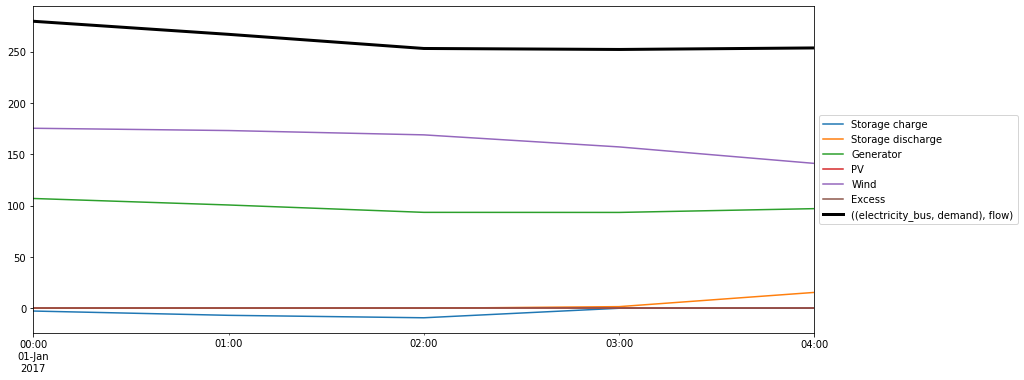

In [7]:
logging.info('Plot flows on electricity bus')
el_sequences = el_bus['sequences']

el_prod = pd.DataFrame(index=timeindex)
el_prod['Storage charge'] = - el_sequences[(('electricity_bus', 'storage'), 'flow')].clip(lower=0)
el_prod['Storage discharge'] = el_sequences[(('storage', 'electricity_bus'), 'flow')].clip(lower=0)
el_prod['Generator']=el_sequences[(('genset', 'electricity_bus'), 'flow')]
el_prod['PV']=el_sequences[(('pv', 'electricity_bus'), 'flow')]
el_prod['Wind']=el_sequences[(('wind', 'electricity_bus'), 'flow')]
el_prod['Excess']=el_sequences[(('electricity_bus', 'excess'), 'flow')]

fig, ax = plt.subplots(figsize=(14, 6))
# line plot
el_prod.plot(ax=ax)
# area plot
#el_prod.plot.area(ax=ax)
el_sequences[(('electricity_bus', 'demand'), 'flow')].plot(ax=ax, linewidth=3, c='k')
legend = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) # legend outside of plot

Check whether constraint is fullfilled by calculating renewable share:

In [8]:
boolean_test = [el_prod['Generator'][t] + (stored_electricity[t] - cap_storage * 0.2) * 1/5 * 0.9 >= stability_limit * el_sequences[(('electricity_bus', 'demand'), 'flow')][t] 
    for t in range(0, len(el_prod.index))]              

In [9]:
if all(boolean_test) == True:
    logging.info("Stability criterion is fullfilled.")
else:
    logging.info("Stability criterion is not fullfilled.")
    peak_demand = el_sequences[(('electricity_bus', 'demand'), 'flow')].max()
    ratio = pd.Series([
                    (el_prod['Generator'][t]
                     + (stored_electricity[t] - cap_storage * 0.2) *1/5 * 0.9
                     - stability_limit * el_sequences[(('electricity_bus', 'demand'), 'flow')][t])
                    / peak_demand
                    for t in range(0, len(el_prod.index))], index=el_prod.index)
    ratio_below_zero = ratio.clip(upper=0)
    if abs(ratio_below_zero.values.min()) < 10 ** (-6):
        logging.warning("Stability criterion is strictly not fullfilled, but deviation is less then e6.")
    else:
        logging.warning("ATTENTION: Stability criterion NOT fullfilled!")
        logging.warning('Number of timesteps not meeting criteria: ' + str(sum(boolean_test)))
        logging.warning('Deviation from stability criterion: ' + str(
                ratio_below_zero.values.mean()) + '(mean) / ' + str(
                ratio_below_zero.values.min()) + '(max).')           

07:27:56-INFO-Stability criterion is not fullfilled.
07:27:56-WARNING-ATTENTION: Stability criterion NOT fullfilled!
07:27:56-WARNING-Number of timesteps not meeting criteria: 0
07:27:56-WARNING-Deviation from stability criterion: -0.0011564654302274266(mean) / -0.0014693130741490563(max).
